
Numerical optimization
======================

Silent substitution can be approached as a [constrained numerical optimization](https://en.wikipedia.org/wiki/Constrained_optimization) problem of the form:

\begin{equation}
\begin{array}{rrclcl}
& \underset{x \in \mathbb{R}^{n}}{\text{minimize}}
&  f(x) \\
& \text{subject to}
& g^{L} \le g(x) \le g^{U} \\
& & x^{L} \le x \le x^{U} ,
\end{array}
\end{equation}

where $x \in \mathbb{R}^{n}$ are the optimization variables (i.e., the primary input weights) whose lower and upper bounds, $x^{L}$ and $x^{U}$, are between 0 and 1 to ensure that the solution is within the gamut of the device, $f(x)$ is the objective function that aims to maximise contrast of the target photoreceptor(s), and $g(x)$ is a constraint function that calculates contrast for the silenced photoreceptor(s), where $g^{L}$ and $g^{U}$ should be zero. In all cases, $x$ is a vector containing the primary input weights. 

`pysilsub.problems.SilentSubstitutionProblem` has an `.optim_solve()` method that uses `SciPy`'s optimisation algorithms to solve a defined problem. By default, it performs a local optimisation with `scipy.optimize.minimize` using the `SLSQP` [sequential quadratic least squares programming](https://docs.scipy.org/doc/scipy-1.8.0/html-scipyorg/reference/optimize.minimize-slsqp.html) solver. 

The objective function, $f(x)$, and the contrast constraint function, $g(x)$, are built into the problem class and are conditioned by the values given to the properties. 


Basic example
-------------

************************************************************
*************** Silent Substitution Problem ****************
************************************************************
Device: STLAB_1 (binocular, left eye)
Observer: StandardColorimetricObserver(age=32, field_size=10)
Ignoring: ['rh']
Minimising: ['sc', 'mc', 'lc']
Modulating: ['mel']
Target contrast: [ 0.5]
Background: None


~~~~~~~~~~~~~~~~~~~~~~~ optim_solve ~~~~~~~~~~~~~~~~~~~~~~~~
> No background specified, will optimise background.
> Performing local optimization with SLSQP.


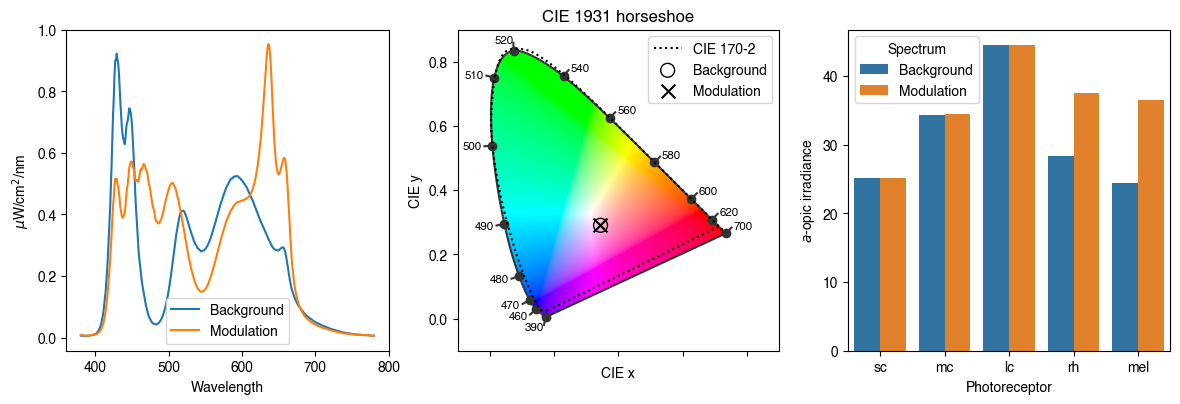

In [1]:
from pysilsub.problems import SilentSubstitutionProblem as SSP

# Instantiate the problem class
ssp = SSP.from_package_data('STLAB_1_York')

# Define problem
ssp.ignore = ['rh']
ssp.modulate = ['mel']
ssp.minimize = ['sc', 'mc', 'lc']
ssp.target_contrast = .5
ssp.print_problem()

# Find solution
solution = ssp.optim_solve(**{'options':{'disp':False}})

# Plot solution
fig = ssp.plot_solution(solution.x)

In [2]:
# Look at the actual contrast values
ssp.print_photoreceptor_contrasts(solution.x)

sc     0.000195
mc     0.000471
lc    -0.000134
rh     0.319336
mel    0.499450
dtype: float64



Maximising contrast
-------------------

If you want `.optim_solve(...)` to maximise contrast rather than aim for a target value, you can set the `target_contrast` property to `'max'` or `'min'`.

************************************************************
*************** Silent Substitution Problem ****************
************************************************************
Device: STLAB_1 (binocular, left eye)
Observer: StandardColorimetricObserver(age=32, field_size=10)
Ignoring: ['rh']
Minimising: ['sc', 'mc', 'lc']
Modulating: ['mel']
Target contrast: [inf]
Background: None


~~~~~~~~~~~~~~~~~~~~~~~ optim_solve ~~~~~~~~~~~~~~~~~~~~~~~~
> No background specified, will optimise background.
> Aiming to maximise contrast.
> Performing local optimization with SLSQP.


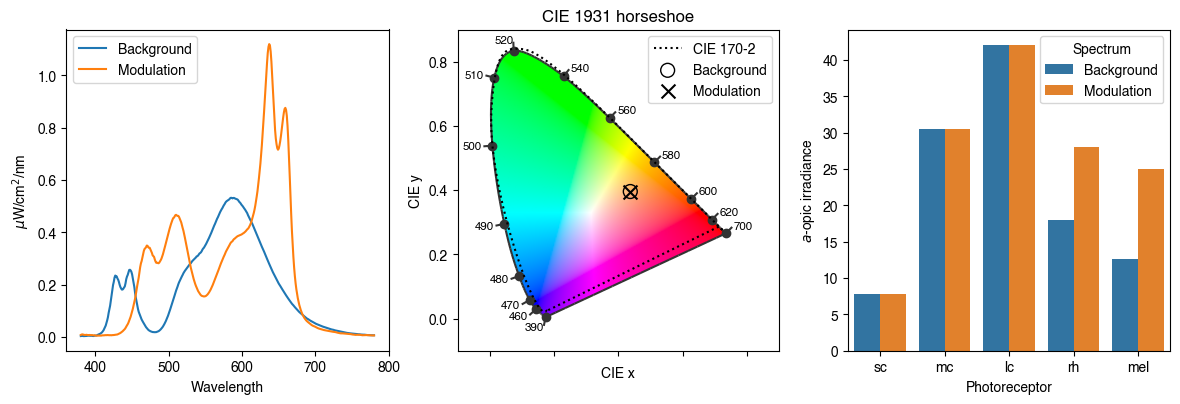

In [3]:
ssp.target_contrast = 'max'
ssp.print_problem()

# Find solution
solution = ssp.optim_solve(**{'options':{'disp':False}})

# Plot solution
_ = ssp.plot_solution(solution.x)

In [4]:
ssp.print_photoreceptor_contrasts(solution.x)

sc     0.000038
mc     0.000024
lc     0.000004
rh     0.555998
mel    0.969204
dtype: float64



### Specifying a background spectrum

Note that in the above examples, both the background and modulation spectra were optimised. However, It often makes sense to stick with a specific background spectrum, particularly if you plan on targeting different photoreceptors in the same experiment. If you specify a background spectrum, `.optim_solve()` will only optimize the modulation spectrum. 

************************************************************
*************** Silent Substitution Problem ****************
************************************************************
Device: STLAB_1 (binocular, left eye)
Observer: StandardColorimetricObserver(age=32, field_size=10)
Ignoring: ['rh']
Minimising: ['sc', 'mc', 'lc']
Modulating: ['mel']
Target contrast: [inf]
Background: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


~~~~~~~~~~~~~~~~~~~~~~~ optim_solve ~~~~~~~~~~~~~~~~~~~~~~~~
> Aiming to maximise contrast.
> Performing local optimization with SLSQP.


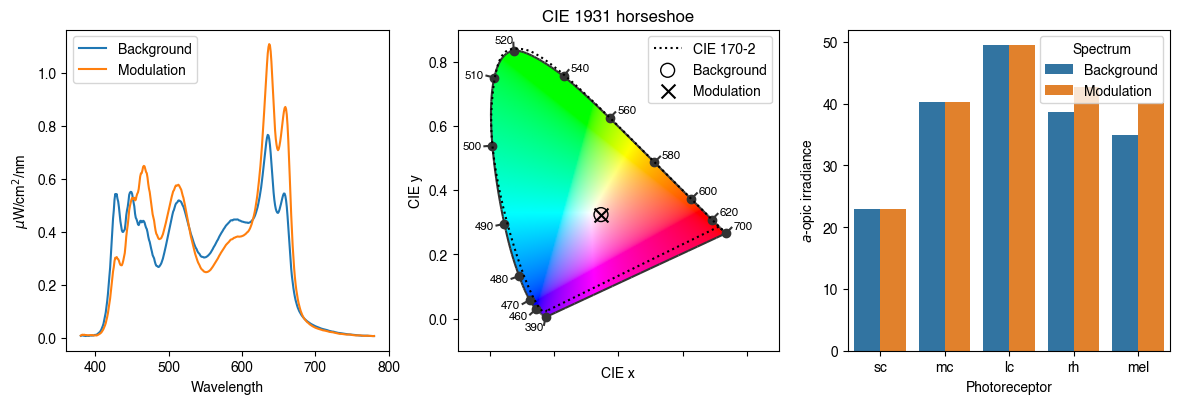

In [5]:
ssp.background = [.5] * ssp.nprimaries  # All primaries, half-max
ssp.target_contrast = 'max'
ssp.print_problem()
solution = ssp.optim_solve(**{'options':{'disp':False}})
_ = ssp.plot_solution(solution.x)

In [6]:
ssp.print_photoreceptor_contrasts(solution.x)

sc     0.000012
mc     0.000004
lc    -0.000014
rh     0.104227
mel    0.147923
dtype: float64


Note that pinning a background spectrum is a big constraint on the optimisation and is why in this case we only got about 14% contrast on melanopsin.


Local vs. global optimisation
-----------------------------

By default, `.optim_solve()` uses *Scipy's* `minimize` function, which is a *local* minimizer. It starts with an initial random guess for the primary inputs and works from that point to minimize the objective function (which in this case was to maximize contrast). 

Due to the random nature of the starting point in the function landscape, the minimum it finds is unlikely to be the global minimum. 

If you have enough time, you can tell `.optim_solve()` to search for the global minimum, in which case it will use *Scipy's* `basinhopping` algorithm to perform a series of local searches, each with a different starting point. 


************************************************************
*************** Silent Substitution Problem ****************
************************************************************
Device: STLAB_1 (binocular, left eye)
Observer: StandardColorimetricObserver(age=32, field_size=10)
Ignoring: ['rh']
Minimising: ['sc', 'mc', 'lc']
Modulating: ['mel']
Target contrast: [inf]
Background: None


~~~~~~~~~~~~~~~~~~~~~~~ optim_solve ~~~~~~~~~~~~~~~~~~~~~~~~
> No background specified, will optimise background.
> Aiming to maximise contrast.
> Performing global optimization with basinhopping and SLSQP
basinhopping step 0: f -0.838032
basinhopping step 1: f -0.576571 trial_f -0.576571 accepted 1  lowest_f -0.838032
basinhopping step 2: f -0.840987 trial_f -0.840987 accepted 1  lowest_f -0.840987
found new global minimum on step 2 with function value -0.840987
basinhopping step 3: f -0.840987 trial_f -0.668947 accepted 0  lowest_f -0.840987
basinhopping step 4: f -0.87087 trial_f -0.87087 accepted

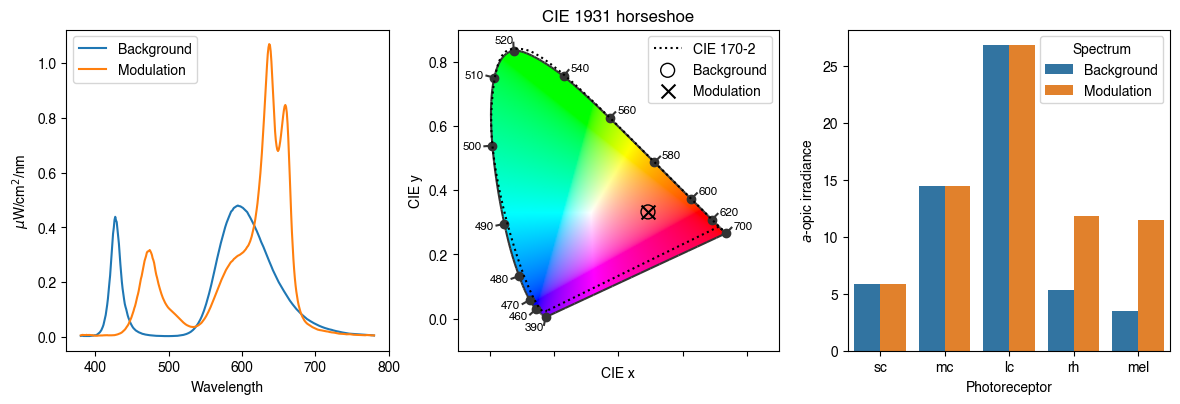

In [7]:
ssp.background = None
ssp.print_problem()
solution = ssp.optim_solve(global_search=True, niter=10)
fig = ssp.plot_solution(solution.x)

In [8]:
ssp.print_photoreceptor_contrasts(solution.x)

sc     0.000000
mc    -0.000111
lc    -0.000000
rh     1.208343
mel    2.316797
dtype: float64
